In [ ]:
import pandas as pd
import ast
from scipy.special import softmax
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

model_names = ["LLaMA3.2-1B", "LLaMA3.2-3B", "Qwen2.5-1.5B", "Qwen2.5-3B"]

info_df = pd.read_csv("Data Files/results.csv")
outputs_df = pd.read_csv("Data Files/results-output.csv")

In [ ]:
results_df = pd.concat([info_df, outputs_df], axis=1)
results_df.to_csv('Data Files/complete_results.csv', index=None)

In [ ]:
for name in model_names:
    results_df[f'{name}_context_weights'] = results_df[f'{name}_context_weights'].apply(ast.literal_eval)
    results_df[f'{name}_question_weights'] = results_df[f'{name}_question_weights'].apply(ast.literal_eval)
    results_df[f'{name}_context_ave'] = results_df[f'{name}_context_ave'].apply(ast.literal_eval)
    results_df[f'{name}_question_ave'] = results_df[f'{name}_question_ave'].apply(ast.literal_eval)
    results_df[f'{name}_total_ave'] = results_df[f'{name}_total_ave'].apply(ast.literal_eval)

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax

def softmax_transform(data):
    return np.array(softmax(data), dtype='float32').reshape(1, -1)

def get_similarity(llm_attn, human_attn):
    normalized_llm = np.array(llm_attn, dtype='float32').reshape(1, -1)
    normalized_human = softmax_transform(human_attn)
    return cosine_similarity(normalized_llm, normalized_human)[0][0]

In [ ]:
for name in model_names:
    results_df[f'{name}_context_similarity'] = results_df.apply(lambda row: get_similarity(row[f'{name}_context_ave'], row[f'{name}_context_weights']), axis=1)
    results_df[f'{name}_question_similarity'] = results_df.apply(lambda row: get_similarity(row[f'{name}_question_ave'], row[f'{name}_question_weights']), axis=1)
    results_df[f'{name}_context_length'] = results_df['context'].apply(lambda x: len(x))
    results_df[f'{name}_question_length'] = results_df['question'].apply(lambda x: len(x))

In [ ]:
context_corrs = [0, 0, 0, 0]
question_corrs = [0, 0, 0, 0]

for i in range(len(model_names)):
    name = model_names[i]
    context_corrs[i] = results_df[f'{name}_context_similarity'].corr(results_df[f'{name}_context_length'])
    question_corrs[i] = results_df[f'{name}_question_similarity'].corr(results_df[f'{name}_question_length'])

In [ ]:
# Get similarity average for all models
similarities = [0, 0, 0, 0]
for i in range(len(model_names)):
    name = model_names[i]
    similarities[i] = (results_df[f'{name}_context_similarity'].mean(), results_df[f'{name}_question_similarity'].mean())
    print(similarities[i])

In [ ]:
cols = []
labels = []
for name in model_names:
    cols.append(f'{name}_context_similarity')
    labels.append(name)

plot = results_df.boxplot(column=cols)
plot.set_xticklabels(labels)
plt.title('Context Attention Cosine Similarity Scores between LLMs and Humans')
plt.show()

In [ ]:
cols = []
labels = []
for name in model_names:
    cols.append(f'{name}_question_similarity')
    labels.append(name)

plot = results_df.boxplot(column=cols)
plot.set_xticklabels(labels)
plt.title('Question Attention Cosine Similarity Scores between LLMs and Humans')
plt.show()

In [ ]:
# Get all grouped types
types = [0, 0, 0, 0]
for i in range(4):
    types[i] = results_df[results_df['type'] == i]

In [ ]:
# Get average attention and similarity to humans on context and question for all types for each model
type_data = [pd.DataFrame() for _ in range(4)]

for i in range(4):
    for name in model_names:
        type_data[i][f'{name}_context_attention_{i}'] = types[i].apply(lambda row: sum(row[f'{name}_context_ave']) / sum(row[f'{name}_total_ave']), axis=1)
        type_data[i][f'{name}_question_attention_{i}'] = types[i].apply(lambda row: sum(row[f'{name}_question_ave']) / sum(row[f'{name}_total_ave']), axis=1)
        type_data[i][f'{name}_context_similarity_{i}'] = types[i][f'{name}_context_similarity']
        type_data[i][f'{name}_question_similarity_{i}'] = types[i][f'{name}_question_similarity']
        

In [ ]:
type_summary = pd.DataFrame(columns=['type', 'model', 'avg_context_attn', 'avg_question_attn', 'avg_context_similarity', 'avg_question_similarity'])

for i in range(4):
    for name in model_names:
        type_summary.loc[len(type_summary)] = [i, name, type_data[i][f'{name}_context_attention_{i}'].mean(), 
                                               type_data[i][f'{name}_question_attention_{i}'].mean(), type_data[i][f'{name}_context_similarity_{i}'].mean(), 
                                               type_data[i][f'{name}_question_similarity_{i}'].mean()]

type_summary.sort_values(by=['model', 'type'], ascending=[True, True]).to_latex()

In [ ]:
model_data = [0, 0, 0, 0]
for x in range(len(model_names)):
    name = model_names[x]
    model_data[x] = pd.concat([type_data[t][[f'{name}_context_attention_{t}', f'{name}_question_attention_{t}', f'{name}_context_similarity_{t}', f'{name}_question_similarity_{t}']].reset_index(drop=True) for t in range(len(type_data))], axis=1)

In [ ]:
cols = []
labels = []

fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for x in range(len(model_names)):
    name = model_names[x]
    cols.append([])
    labels.append([])
    for i in range(4):
        cols[x].append(f'{name}_context_attention_{i}')
        labels[x].append(f'Type {i}')
    model_data[x].boxplot(column=cols[x], ax=axes[x//2, x%2])
    axes[x//2, x%2].set_title(model_names[x])
    axes[x//2, x%2].set_xticklabels(labels[x])
    
plt.suptitle('Context Attention Ratio for Different Context-Question Pair Types')
plt.tight_layout()
plt.show()

In [ ]:
cols = []
labels = []

fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for x in range(len(model_names)):
    name = model_names[x]
    cols.append([])
    labels.append([])
    for i in range(4):
        cols[x].append(f'{name}_question_attention_{i}')
        labels[x].append(f'Type {i}')
    model_data[x].boxplot(column=cols[x], ax=axes[x//2, x%2])
    axes[x//2, x%2].set_title(model_names[x])
    axes[x//2, x%2].set_xticklabels(labels[x])
    
plt.suptitle('Question Attention Ratio for Different Context-Question Pair Types')    
plt.tight_layout()
plt.show()

In [ ]:
cols = []
labels = []

fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for x in range(len(model_names)):
    name = model_names[x]
    cols.append([])
    labels.append([])
    for i in range(4):
        cols[x].append(f'{name}_context_similarity_{i}')
        labels[x].append(f'Type {i}')
    model_data[x].boxplot(column=cols[x], ax=axes[x//2, x%2])
    axes[x//2, x%2].set_title(model_names[x])
    axes[x//2, x%2].set_xticklabels(labels[x])

plt.suptitle('Context Attention Cosine Similarity for Different Context-Question Pair Types')    
plt.tight_layout()
plt.show()

In [ ]:
cols = []
labels = []

fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for x in range(len(model_names)):
    name = model_names[x]
    cols.append([])
    labels.append([])
    for i in range(4):
        cols[x].append(f'{name}_question_similarity_{i}')
        labels[x].append(f'Type {i}')
    model_data[x].boxplot(column=cols[x], ax=axes[x//2, x%2])
    axes[x//2, x%2].set_title(model_names[x])
    axes[x//2, x%2].set_xticklabels(labels[x])

plt.suptitle('Question Attention Cosine Similarity for Different Context-Question Pair Types')   
plt.tight_layout()
plt.show()

In [ ]:
#Filtering to remove model hallucinations
import pandas as pd
import ast
from scipy.special import softmax

annotated_results_df = pd.read_csv('Data Files/annotated_complete_results.csv')

In [ ]:
name = "Qwen2.5-1.5B"
filtered_df = annotated_results_df[annotated_results_df[f'{name}_hallucinated'] == False]

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax

def softmax_transform(data):
    return np.array(softmax(data), dtype='float32').reshape(1, -1)

def get_similarity(llm_attn, human_attn):
    normalized_llm = np.array(llm_attn, dtype='float32').reshape(1, -1)
    normalized_human = softmax_transform(human_attn)
    return cosine_similarity(normalized_llm, normalized_human)[0][0]


In [ ]:
for name in model_names:
    filtered_df[f'{name}_context_weights'] = filtered_df[f'{name}_context_weights'].apply(ast.literal_eval)
    filtered_df[f'{name}_question_weights'] = filtered_df[f'{name}_question_weights'].apply(ast.literal_eval)
    filtered_df[f'{name}_context_ave'] = filtered_df[f'{name}_context_ave'].apply(ast.literal_eval)
    filtered_df[f'{name}_question_ave'] = filtered_df[f'{name}_question_ave'].apply(ast.literal_eval)
    filtered_df[f'{name}_total_ave'] = filtered_df[f'{name}_total_ave'].apply(ast.literal_eval)

In [ ]:
for name in model_names:
    filtered_df[f'{name}_context_similarity'] = filtered_df.apply(lambda row: get_similarity(row[f'{name}_context_ave'], row[f'{name}_context_weights']), axis=1)
    filtered_df[f'{name}_question_similarity'] = filtered_df.apply(lambda row: get_similarity(row[f'{name}_question_ave'], row[f'{name}_question_weights']), axis=1)

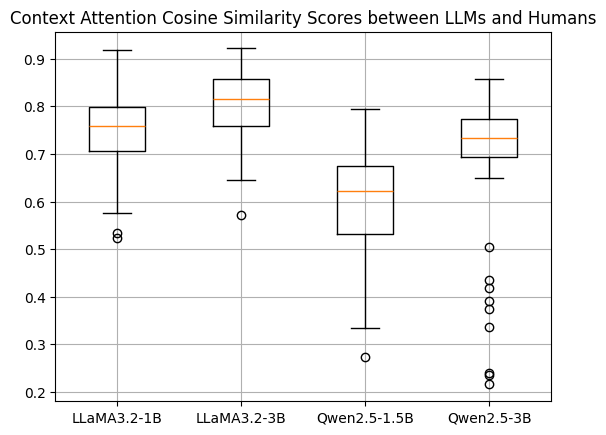

In [ ]:
labels = []
for name in model_names:
    labels.append(name)

plt.boxplot([filtered_df[f'{model_names[0]}_context_similarity'], filtered_df[f'{model_names[1]}_context_similarity'],
            filtered_df[f'{model_names[2]}_context_similarity'], filtered_df[f'{model_names[3]}_context_similarity']], labels=labels)
plt.title('Context Attention Cosine Similarity Scores between LLMs and Humans')
plt.grid(True)
plt.show()

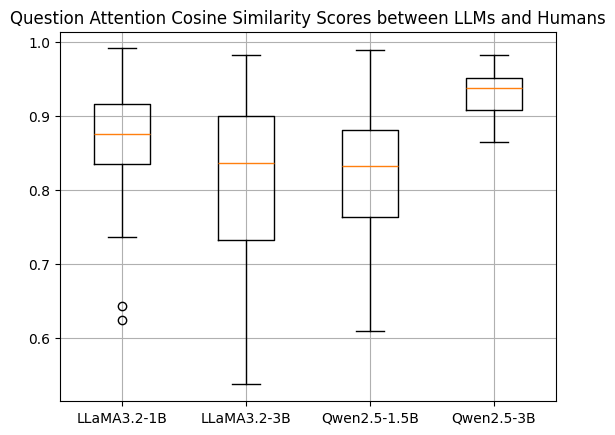

In [ ]:
plt.boxplot([filtered_df[f'{model_names[0]}_question_similarity'], filtered_df[f'{model_names[1]}_question_similarity'],
            filtered_df[f'{model_names[2]}_question_similarity'], filtered_df[f'{model_names[3]}_question_similarity']], labels=labels)
plt.title('Question Attention Cosine Similarity Scores between LLMs and Humans')
plt.grid(True)
plt.show()

In [ ]:
name = model_names[2]

In [ ]:
# Get all grouped types
types = [0, 0, 0, 0]
for i in range(4):
    types[i] = filtered_df[filtered_df['type'] == i]

In [ ]:
type_data = [pd.DataFrame() for _ in range(4)]

for i in range(4):
    type_data[i][f'{name}_context_attention_{i}'] = types[i].apply(lambda row: sum(row[f'{name}_context_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    type_data[i][f'{name}_question_attention_{i}'] = types[i].apply(lambda row: sum(row[f'{name}_question_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    type_data[i][f'{name}_context_similarity_{i}'] = types[i][f'{name}_context_similarity']
    type_data[i][f'{name}_question_similarity_{i}'] = types[i][f'{name}_question_similarity']


In [ ]:
type_summary = pd.DataFrame(columns=['type', 'model', 'avg_context_attn', 'avg_question_attn', 'avg_context_similarity', 'avg_question_similarity'])

for i in range(4):
    type_summary.loc[len(type_summary)] = [i, name, type_data[i][f'{name}_context_attention_{i}'].mean(), 
                                            type_data[i][f'{name}_question_attention_{i}'].mean(), type_data[i][f'{name}_context_similarity_{i}'].mean(), 
                                            type_data[i][f'{name}_question_similarity_{i}'].mean()]

type_summary.sort_values(by=['model', 'type'], ascending=[True, True]).to_latex()

'\\begin{tabular}{lrlrrrr}\n\\toprule\n & type & model & avg_context_attn & avg_question_attn & avg_context_similarity & avg_question_similarity \\\\\n\\midrule\n0 & 0 & Qwen2.5-1.5B & 0.165058 & 0.045666 & 0.671102 & 0.820700 \\\\\n1 & 1 & Qwen2.5-1.5B & 0.075673 & 0.044692 & 0.576192 & 0.858614 \\\\\n2 & 2 & Qwen2.5-1.5B & 0.098071 & 0.072771 & 0.606846 & 0.804959 \\\\\n3 & 3 & Qwen2.5-1.5B & 0.071987 & 0.072843 & 0.570341 & 0.827003 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
name = model_names[2]
model_data = pd.concat([type_data[t][[f'{name}_context_attention_{t}', f'{name}_question_attention_{t}', f'{name}_context_similarity_{t}', f'{name}_question_similarity_{t}']].reset_index(drop=True) for t in range(len(type_data))], axis=1)

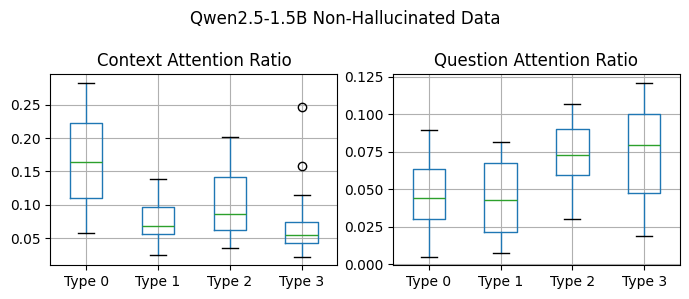

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

cols = []
labels = []

for i in range(4):
    cols.append(f'{name}_context_attention_{i}')
    labels.append(f'Type {i}')
model_data.boxplot(column=cols, ax=axes[0])
axes[0].set_title('Context Attention Ratio')
axes[0].set_xticklabels(labels)

cols = []
labels = []

for i in range(4):
    cols.append(f'{name}_question_attention_{i}')
    labels.append(f'Type {i}')
model_data.boxplot(column=cols, ax=axes[1])
axes[1].set_title('Question Attention Ratio')
axes[1].set_xticklabels(labels)

plt.suptitle('Qwen2.5-1.5B Non-Hallucinated Data')
plt.tight_layout()
plt.show()

# QWEN 2.5

In [ ]:
name = "Qwen2.5-1.5B"
hallucinated_df = annotated_results_df[annotated_results_df[f'{name}_hallucinated'] == True]

In [ ]:
for name in model_names:
    hallucinated_df[f'{name}_context_weights'] = hallucinated_df[f'{name}_context_weights'].apply(ast.literal_eval)
    hallucinated_df[f'{name}_question_weights'] = hallucinated_df[f'{name}_question_weights'].apply(ast.literal_eval)
    hallucinated_df[f'{name}_context_ave'] = hallucinated_df[f'{name}_context_ave'].apply(ast.literal_eval)
    hallucinated_df[f'{name}_question_ave'] = hallucinated_df[f'{name}_question_ave'].apply(ast.literal_eval)
    hallucinated_df[f'{name}_total_ave'] = hallucinated_df[f'{name}_total_ave'].apply(ast.literal_eval)

In [ ]:
for name in model_names:
    hallucinated_df[f'{name}_context_similarity'] = hallucinated_df.apply(lambda row: get_similarity(row[f'{name}_context_ave'], row[f'{name}_context_weights']), axis=1)
    hallucinated_df[f'{name}_question_similarity'] = hallucinated_df.apply(lambda row: get_similarity(row[f'{name}_question_ave'], row[f'{name}_question_weights']), axis=1)

In [ ]:
# Get similarity average for hallucinated responses
for name in model_names:
    model = (hallucinated_df[f'{name}_context_similarity'].mean(), hallucinated_df[f'{name}_question_similarity'].mean())
    print(f'{name}: {model}')

LLaMA3.2-1B: (np.float32(0.7336628), np.float32(0.8639713))
LLaMA3.2-3B: (np.float32(0.8013755), np.float32(0.83988035))
Qwen2.5-1.5B: (np.float32(0.64825356), np.float32(0.7533635))
Qwen2.5-3B: (np.float32(0.64863735), np.float32(0.9382559))


In [ ]:
for name in model_names:
    model = (filtered_df[f'{name}_context_similarity'].mean(), filtered_df[f'{name}_question_similarity'].mean())
    print(f'{name}: {model}')

LLaMA3.2-1B: (np.float32(0.7511344), np.float32(0.8674709))
LLaMA3.2-3B: (np.float32(0.8039748), np.float32(0.8100082))
Qwen2.5-1.5B: (np.float32(0.6078829), np.float32(0.8250861))
Qwen2.5-3B: (np.float32(0.6911096), np.float32(0.93117076))


In [ ]:
# Get all grouped types
hallu_types = [0, 0, 0, 0]
for i in range(4):
    hallu_types[i] = hallucinated_df[hallucinated_df['type'] == i]

In [ ]:
name = model_names[2]
hallu_type_data = [pd.DataFrame() for _ in range(4)]

for i in range(4):
    hallu_type_data[i][f'{name}_context_attention'] = hallu_types[i].apply(lambda row: sum(row[f'{name}_context_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    hallu_type_data[i][f'{name}_question_attention'] = hallu_types[i].apply(lambda row: sum(row[f'{name}_question_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    hallu_type_data[i][f'{name}_context_similarity'] = hallu_types[i][f'{name}_context_similarity']
    hallu_type_data[i][f'{name}_question_similarity'] = hallu_types[i][f'{name}_question_similarity']


In [ ]:
hallu_type_summary = pd.DataFrame(columns=['type', 'model', 'avg_context_attn', 'avg_question_attn', 'avg_context_similarity', 'avg_question_similarity'])

for i in range(4):
    if hallu_types[i].shape[0] == 0:
        continue

    hallu_type_summary.loc[len(hallu_type_summary)] = [i, name, hallu_type_data[i][f'{name}_context_attention'].mean(), 
                                            hallu_type_data[i][f'{name}_question_attention'].mean(), hallu_types[i][f'{name}_context_similarity'].mean(), 
                                            hallu_types[i][f'{name}_question_similarity'].mean()]

hallu_type_summary.sort_values(by=['model', 'type'], ascending=[True, True]).to_latex()

'\\begin{tabular}{lrlrrrr}\n\\toprule\n & type & model & avg_context_attn & avg_question_attn & avg_context_similarity & avg_question_similarity \\\\\n\\midrule\n0 & 0 & Qwen2.5-1.5B & 0.067063 & 0.038920 & 0.605054 & 0.857533 \\\\\n1 & 1 & Qwen2.5-1.5B & 0.179017 & 0.024961 & 0.700826 & 0.741424 \\\\\n2 & 2 & Qwen2.5-1.5B & 0.015739 & 0.023235 & 0.384826 & 0.658325 \\\\\n3 & 3 & Qwen2.5-1.5B & 0.224511 & 0.027833 & 0.766189 & 0.739906 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))

cols = []
labels = []
for i in range(4):
    labels.append(f"T{i} (H)")
    labels.append(f"T{i}")

for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_context_attention'].dropna())
    cols.append(model_data[f'{name}_context_attention_{i}'].dropna())
axes[0].boxplot(cols, labels=labels)
axes[0].set_title('Context Attention Ratio')

cols = []
labels = []
for i in range(4):
    labels.append(f"T{i} (H)")
    labels.append(f"T{i}")

for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_question_attention'].dropna())
    cols.append(model_data[f'{name}_question_attention_{i}'].dropna())
axes[1].boxplot(cols, labels=labels)
axes[1].set_title('Question Attention Ratio')

plt.suptitle('Qwen2.5-1.5B Hallucinated vs Non-Hallucinated Average Attentions')
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))

cols = []
for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_context_similarity'])
    cols.append(model_data[f'{name}_context_similarity_{i}'].dropna())
axes[0].boxplot(cols, labels=labels)
axes[0].set_title('Context Similarity')

cols = []
for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_question_similarity'])
    cols.append(model_data[f'{name}_question_similarity_{i}'].dropna())
axes[1].boxplot(cols, labels=labels)
axes[1].set_title('Question Similarity')

plt.suptitle('Qwen2.5-1.5B Hallucinated vs Non-Hallucinated Cosine Similarities')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy import stats

# Example data (two groups)
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_context_attention'])
    group2 = np.array(model_data[f'{name}_context_attention_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()


In [ ]:
# Example data (two groups)
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_question_attention'])
    group2 = np.array(model_data[f'{name}_question_attention_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

In [ ]:
# Example data (two groups)
print(f"Model: {name}")
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_context_similarity'])
    group2 = np.array(model_data[f'{name}_context_similarity_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print(f"Type {i}")
    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

In [ ]:
print(f"Model: {name}")
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_question_similarity'])
    group2 = np.array(model_data[f'{name}_question_similarity_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print(f"Type {i}")
    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

# LLaMA 1B

In [ ]:
# Get all grouped types
hallu_types = [0, 0, 0, 0]
for i in range(4):
    hallu_types[i] = hallucinated_df[hallucinated_df['type'] == i]

In [ ]:
name = model_names[0]
hallu_type_data = [pd.DataFrame() for _ in range(4)]
for i in range(4):
    hallu_type_data[i][f'{name}_context_attention'] = hallu_types[i].apply(lambda row: sum(row[f'{name}_context_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    hallu_type_data[i][f'{name}_question_attention'] = hallu_types[i].apply(lambda row: sum(row[f'{name}_question_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    hallu_type_data[i][f'{name}_context_similarity'] = hallu_types[i][f'{name}_context_similarity']
    hallu_type_data[i][f'{name}_question_similarity'] = hallu_types[i][f'{name}_question_similarity']


In [ ]:
hallu_type_summary = pd.DataFrame(columns=['type', 'model', 'avg_context_attn', 'avg_question_attn', 'avg_context_similarity', 'avg_question_similarity'])

for i in range(4):
    if hallu_types[i].shape[0] == 0:
        continue

    hallu_type_summary.loc[len(hallu_type_summary)] = [i, name, hallu_type_data[i][f'{name}_context_attention'].mean(), 
                                            hallu_type_data[i][f'{name}_question_attention'].mean(), hallu_types[i][f'{name}_context_similarity'].mean(), 
                                            hallu_types[i][f'{name}_question_similarity'].mean()]

hallu_type_summary.sort_values(by=['model', 'type'], ascending=[True, True]).to_latex()

In [ ]:
# Get all grouped types
types = [0, 0, 0, 0]
for i in range(4):
    types[i] = filtered_df[filtered_df['type'] == i]

In [ ]:
type_data = [pd.DataFrame() for _ in range(4)]

for i in range(4):
    type_data[i][f'{name}_context_attention_{i}'] = types[i].apply(lambda row: sum(row[f'{name}_context_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    type_data[i][f'{name}_question_attention_{i}'] = types[i].apply(lambda row: sum(row[f'{name}_question_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    type_data[i][f'{name}_context_similarity_{i}'] = types[i][f'{name}_context_similarity']
    type_data[i][f'{name}_question_similarity_{i}'] = types[i][f'{name}_question_similarity']


In [ ]:
type_summary = pd.DataFrame(columns=['type', 'model', 'avg_context_attn', 'avg_question_attn', 'avg_context_similarity', 'avg_question_similarity'])

for i in range(4):
    type_summary.loc[len(type_summary)] = [i, name, type_data[i][f'{name}_context_attention_{i}'].mean(), 
                                            type_data[i][f'{name}_question_attention_{i}'].mean(), type_data[i][f'{name}_context_similarity_{i}'].mean(), 
                                            type_data[i][f'{name}_question_similarity_{i}'].mean()]

type_summary.sort_values(by=['model', 'type'], ascending=[True, True]).to_latex()

In [ ]:
model_data = pd.concat([type_data[t][[f'{name}_context_attention_{t}', f'{name}_question_attention_{t}', f'{name}_context_similarity_{t}', f'{name}_question_similarity_{t}']].reset_index(drop=True) for t in range(len(type_data))], axis=1)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))

cols = []
labels = []
for i in range(4):
    labels.append(f"T{i} (H)")
    labels.append(f"T{i}")

for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_context_attention'].dropna())
    cols.append(model_data[f'{name}_context_attention_{i}'].dropna())
axes[0].boxplot(cols, labels=labels)
axes[0].set_title('Context Attention Ratio')

cols = []
labels = []
for i in range(4):
    labels.append(f"T{i} (H)")
    labels.append(f"T{i}")
    
for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_question_attention'].dropna())
    cols.append(model_data[f'{name}_question_attention_{i}'].dropna())
axes[1].boxplot(cols, labels=labels)
axes[1].set_title('Question Attention Ratio')

plt.suptitle('Qwen2.5-1.5B Hallucinated vs Non-Hallucinated Average Attentions')
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))

cols = []
labels = []
for i in range(4):
    labels.append(f"T{i} (H)")
    labels.append(f"T{i}")

for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_context_similarity'].dropna())
    cols.append(model_data[f'{name}_context_similarity_{i}'].dropna())
axes[0].boxplot(cols, labels=labels)
axes[0].set_title('Context Similarity')

cols = []
labels = []
for i in range(4):
    labels.append(f"T{i} (H)")
    labels.append(f"T{i}")
    
for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_question_similarity'].dropna())
    cols.append(model_data[f'{name}_question_similarity_{i}'].dropna())
axes[1].boxplot(cols, labels=labels)
axes[1].set_title('Question Similarity')

plt.suptitle('Qwen2.5-1.5B Hallucinated vs Non-Hallucinated Cosine Similarities')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy import stats

# Example data (two groups)
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_context_attention'])
    group2 = np.array(model_data[f'{name}_context_attention_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()


In [ ]:
# Example data (two groups)
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_question_attention'])
    group2 = np.array(model_data[f'{name}_question_attention_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

In [ ]:
# Example data (two groups)
print(f"Model: {name}")
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_context_similarity'])
    group2 = np.array(model_data[f'{name}_context_similarity_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print(f"Type {i}")
    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

In [ ]:
print(f"Model: {name}")
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_question_similarity'])
    group2 = np.array(model_data[f'{name}_question_similarity_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print(f"Type {i}")
    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

### SECTION LAST

In [ ]:
import pandas as pd
import ast
from scipy.special import softmax
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

model_names = ["LLaMA3.2-1B", "LLaMA3.2-3B", "Qwen2.5-1.5B", "Qwen2.5-3B"]

results_df = pd.read_csv('Data Files/annotated_complete_results.csv')

In [ ]:
for name in model_names:
    results_df[f'{name}_context_weights'] = results_df[f'{name}_context_weights'].apply(ast.literal_eval)
    results_df[f'{name}_question_weights'] = results_df[f'{name}_question_weights'].apply(ast.literal_eval)
    results_df[f'{name}_context_ave'] = results_df[f'{name}_context_ave'].apply(ast.literal_eval)
    results_df[f'{name}_question_ave'] = results_df[f'{name}_question_ave'].apply(ast.literal_eval)
    results_df[f'{name}_total_ave'] = results_df[f'{name}_total_ave'].apply(ast.literal_eval)

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax

def softmax_transform(data):
    return np.array(softmax(data), dtype='float32').reshape(1, -1)

def get_similarity(llm_attn, human_attn):
    normalized_llm = np.array(llm_attn, dtype='float32').reshape(1, -1)
    normalized_human = softmax_transform(human_attn)
    return cosine_similarity(normalized_llm, normalized_human)[0][0]

In [ ]:
for name in model_names:
    results_df[f'{name}_context_similarity'] = results_df.apply(lambda row: get_similarity(row[f'{name}_context_ave'], row[f'{name}_context_weights']), axis=1)
    results_df[f'{name}_question_similarity'] = results_df.apply(lambda row: get_similarity(row[f'{name}_question_ave'], row[f'{name}_question_weights']), axis=1)
    results_df[f'{name}_context_length'] = results_df['context'].apply(lambda x: len(x))
    results_df[f'{name}_question_length'] = results_df['question'].apply(lambda x: len(x))
    results_df[f'{name}_context_attention'] = results_df.apply(lambda row: sum(row[f'{name}_context_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    results_df[f'{name}_question_attention'] = results_df.apply(lambda row: sum(row[f'{name}_question_ave']) / sum(row[f'{name}_total_ave']), axis=1)

In [ ]:
context_corrs = [0, 0, 0, 0]
question_corrs = [0, 0, 0, 0]

for i in range(len(model_names)):
    name = model_names[i]
    context_corrs[i] = results_df[f'{name}_context_similarity'].corr(results_df[f'{name}_context_length'])
    question_corrs[i] = results_df[f'{name}_question_similarity'].corr(results_df[f'{name}_question_length'])

In [ ]:
answer_dfs = []
instruction_dfs = []
non_hallu_dfs = results_df

for name in model_names:
    answer_dfs.append(results_df[results_df[f'{name}_hallucination_type'] == "answer"])
    instruction_dfs.append(results_df[results_df[f'{name}_hallucination_type'] == "instruction"])
    non_hallu_dfs = non_hallu_dfs[results_df[f'{name}_hallucinated'] == False]

    print(results_df[results_df[f'{name}_hallucination_type'] == "answer"].index)
    print(results_df[results_df[f'{name}_hallucination_type'] == "instruction"].index)
    print(non_hallu_dfs[results_df[f'{name}_hallucinated'] == False].index)

In [ ]:
hallu_count = []

for i in range(4):
    hallu_count.append([[0, 0, 0, 0], [0, 0, 0, 0]])

for i in range(4):
    for y in range(len(answer_dfs)):
        name = model_names[y]
        ans_df = answer_dfs[y]
        temp_df = ans_df[ans_df['type'] == i]
        ins_df = instruction_dfs[y]
        temp2_df = ins_df[ins_df['type'] == i]

        if not temp_df.empty:
            hallu_count[y][0][i] += temp_df.shape[0]

        if not temp2_df.empty:
            hallu_count[y][1][i] += temp2_df.shape[0]

In [ ]:
for y in range(len(answer_dfs)):
    for i in range(4):
        name = model_names[y]
        print(f"{name} (Type: {i}): {hallu_count[y][0][i]} | {hallu_count[y][1][i]}")

In [ ]:
stats_df = pd.DataFrame({
    "Model": [],
    "type": [],
    "Answer": [],
    "Instruction": [],
    "Total": []
})

for y in range(len(answer_dfs)):
    for i in range(4):
        name = model_names[y]

        stats_df = pd.concat(
            [stats_df, pd.DataFrame({
                "Model": [name],
                "type": [i],
                "Answer": [hallu_count[y][0][i]],
                "Instruction": [hallu_count[y][1][i]],
                "Total": [hallu_count[y][0][i] + hallu_count[y][1][i]]
            })],
            ignore_index=True
        )

stats_df = stats_df.astype(
    {
        "Model": "string",
        "type": "int32",
        "Answer": "int32",
        "Instruction": "int32",
        "Total": "int32"
    }
)

stats_df

In [ ]:
grouped_by_model = (stats_df.groupby(["Model"]))[["Answer", "Instruction", "Total"]].sum().reset_index()
grouped_by_model["Answer"] = grouped_by_model["Answer"].apply(lambda x: x / 80.0)
grouped_by_model["Total"] = grouped_by_model["Total"].apply(lambda x: x / 80.0)
grouped_by_model["Instruction"] = grouped_by_model["Instruction"].apply(lambda x: x / 80.0)
grouped_by_model.to_latex()

In [ ]:
def rename(df, name):
    rename_dict = dict()
    rename_dict[f"{name}_context_attention"] = "context_attention"
    rename_dict[f"{name}_question_attention"] = "question_attention"
    rename_dict[f"{name}_context_similarity"] = "context_similarity"
    rename_dict[f"{name}_question_similarity"] = "question_similarity"
    return df.rename(columns=rename_dict)

In [ ]:
# Get all grouped types
answer_hallu_types = []
instruction_hallu_types = []
non_hallu_types = []

for i in range(4):
    answer_hallu_types.append(pd.DataFrame({"context_attention": [], 
                                            "question_attention": [],
                                            "context_similarity": [],
                                            "question_similarity": []}))
    instruction_hallu_types.append(pd.DataFrame({"context_attention": [], 
                                            "question_attention": [],
                                            "context_similarity": [],
                                            "question_similarity": []}))
    non_hallu_types.append(pd.DataFrame({"context_attention": [], 
                                            "question_attention": [],
                                            "context_similarity": [],
                                            "question_similarity": []}))

for i in range(4):
    for y in range(len(answer_dfs)):
        name = model_names[y]
        var = pd.DataFrame({"context_attention": [], 
                    "question_attention": [],
                    "context_similarity": [],
                    "question_similarity": []})

        ans_df = answer_dfs[y]
        temp_df = ans_df[ans_df['type'] == i]

        if not temp_df.empty:
            answer_hallu_types[i] = pd.concat(
                [answer_hallu_types[i], rename(df=temp_df, name=name)],
                ignore_index=True
            )

    for y in range(len(instruction_dfs)):
        name = model_names[y]
        var = pd.DataFrame({"context_attention": [], 
                    "question_attention": [],
                    "context_similarity": [],
                    "question_similarity": []})

        ins_df = instruction_dfs[y]
        temp_df = ins_df[ins_df['type'] == i]

        if not temp_df.empty:
            instruction_hallu_types[i] = pd.concat(
                [instruction_hallu_types[i], rename(df=temp_df, name=name)],
                ignore_index=True
            )

    for name in model_names:
        var = pd.DataFrame({"context_attention": [], 
                    "question_attention": [],
                    "context_similarity": [],
                    "question_similarity": []})

        non_df = non_hallu_dfs
        temp_df = non_df[non_df['type'] == i]

        if not temp_df.empty:
            non_hallu_types[i] = pd.concat(
                [non_hallu_types[i], rename(df=temp_df, name=name)],
                ignore_index=True
            )

In [ ]:
for i in range(4):
    group1 = np.array(answer_hallu_types[i]['context_attention'].dropna())
    group2 = np.array(non_hallu_types[i]['context_attention'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

In [ ]:
for i in range(4):
    group1 = np.array(answer_hallu_types[i]['question_attention'].dropna())
    group2 = np.array(non_hallu_types[i]['question_attention'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

In [ ]:
for i in range(4):
    group1 = np.array(answer_hallu_types[i]['context_similarity'].dropna())
    group2 = np.array(non_hallu_types[i]['context_similarity'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

In [ ]:
for i in range(4):
    group1 = np.array(answer_hallu_types[i]['question_similarity'].dropna())
    group2 = np.array(non_hallu_types[i]['question_similarity'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()